# DeepLearning ちょっと横道

## 目的
前回まで作ってきたモデルで MNIST 以外の学習用データでどうなるかを確認する。

## タイタニック号乗客の生存予測モデル

### Kaggle
データ解析のSkillを競うCompetitionサイト

### Titanic: Machine Learning from Disaster
https://www.kaggle.com/c/titanic/

参考サイト: タイタニック号乗客の生存予測モデルを立ててみる - Qiita http://qiita.com/suzumi/items/8ce18bc90c942663d1e6



## pandas
行列のデータ整形が得意なライブラリ  
anacondaに入ってる

In [211]:
import pandas as pd

df_sample = pd.read_csv("sample.csv")
print(df_sample)

   a  b  c  d
0  0  0  0  0
1  0  0  0  0
2  0  0  0  0
3  0  0  0  0


In [212]:
print(df_sample['a'])

0    0
1    0
2    0
3    0
Name: a, dtype: int64


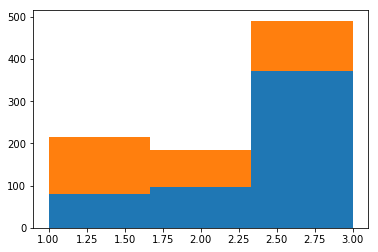

In [213]:
import matplotlib.pyplot as plt

df = pd.read_csv("train.csv").replace("male",0).replace("female",1)

split_data = []
for survived in [0,1]:
    split_data.append(df[df.Survived==survived])

temp = [i["Pclass"].dropna() for i in split_data]
plt.hist(temp, histtype="barstacked", bins=3)
plt.show()

In [214]:
import numpy as np
import sys, os
from collections import OrderedDict

class Affine:
    def __init__(self, W, b):
        self.W = W
        self.b = b
        self.x = None
        self.dW = None
        self.db = None

    def forward(self, x):
        self.x = x
        out = np.dot(x, self.W) + self.b

        return out

    def backward(self, dout):
        dx = np.dot(dout, self.W.T)
        self.dW = np.dot(self.x.T, dout)
        self.db = np.sum(dout, axis=0)

        return dx
    
class SoftmaxWithLoss:
    def __init__(self):
        self.loss = None
        self.y = None
        self.x = None

    def forward(self, x, t):
        self.t = t
        self.y = softmax(x)
        self.loss = cross_entropy_error(self.y, self.t)

        return self.loss

    def backward(self, dout=1):
        batch_size = self.t.shape[0]
        dx = (self.y - self.t) / batch_size

        return dx

class Relu:
    def __init__(self):
        self.mask = None

    def forward(self, x):
        self.mask = (x <= 0)
        out = x.copy()
        out[self.mask] = 0

        return out

    def backward(self, dout):
        dout[self.mask] = 0
        dx = dout

        return dx

def softmax(x):
    if x.ndim == 2:
        x = x.T
        x = x - np.max(x, axis=0)
        y = np.exp(x) / np.sum(np.exp(x), axis=0)
        return y.T 

    x = x - np.max(x) # オーバーフロー対策
    return np.exp(x) / np.sum(np.exp(x))

def cross_entropy_error(y, t):
    if y.ndim == 1:
        t = t.reshape(1, t.size)
        y = y.reshape(1, y.size)
        
    # 教師データがone-hot-vectorの場合、正解ラベルのインデックスに変換
    if t.size == y.size:
        t = t.argmax(axis=1)
             
    batch_size = y.shape[0]
    return -np.sum(np.log(y[np.arange(batch_size), t])) / batch_size

class TwoLayerNet:

    def __init__(self, input_size, hidden_size, output_size, weight_init_std = 0.01):
        # 重みの初期化
        self.params = {}
        self.params['W1'] = weight_init_std * np.random.randn(input_size, hidden_size)
        self.params['b1'] = np.zeros(hidden_size)
        self.params['W2'] = weight_init_std * np.random.randn(hidden_size, output_size) 
        self.params['b2'] = np.zeros(output_size)

        # レイヤの生成
        self.layers = OrderedDict()
        self.layers['Affine1'] = Affine(self.params['W1'], self.params['b1'])
        self.layers['Relu1'] = Relu()
        self.layers['Affine2'] = Affine(self.params['W2'], self.params['b2'])

        self.lastLayer = SoftmaxWithLoss()
        
    def predict(self, x):
        for layer in self.layers.values():
            x = layer.forward(x)
        
        return x
        
    # x:入力データ, t:教師データ
    def loss(self, x, t):
        y = self.predict(x)
        return self.lastLayer.forward(y, t)
    
    def accuracy(self, x, t):
        y = self.predict(x)
        y = np.argmax(y, axis=1)
        if t.ndim != 1 : t = np.argmax(t, axis=1)
        
        accuracy = np.sum(y == t) / float(x.shape[0])
        return accuracy
        
    def gradient(self, x, t):
        # forward
        self.loss(x, t)

        # backward
        dout = 1
        dout = self.lastLayer.backward(dout)
        
        layers = list(self.layers.values())
        layers.reverse()
        for layer in layers:
            dout = layer.backward(dout)

        # 設定
        grads = {}
        grads['W1'], grads['b1'] = self.layers['Affine1'].dW, self.layers['Affine1'].db
        grads['W2'], grads['b2'] = self.layers['Affine2'].dW, self.layers['Affine2'].db

        return grads

def backprop_learn(x_train, t_train, test_data):
    
    network = TwoLayerNet(input_size=6, hidden_size=10, output_size=2)

    iters_num = 102*100+1
    train_size = x_train.shape[0]
    batch_size = 102
    learning_rate = 0.1
    train_loss_list = []
    train_acc_list = []
    test_acc_list = []
    iter_per_epoch = max(train_size / batch_size, 1)
    print(iter_per_epoch)
    for i in range(iters_num):
        batch_mask = np.random.choice(train_size, batch_size)
        x_batch = x_train[batch_mask]
        t_batch = t_train[batch_mask]

        grad = network.gradient(x_batch, t_batch)

        for key in ('W1', 'b1', 'W2', 'b2'):
            network.params[key] -= learning_rate * grad[key]

        loss = network.loss(x_batch, t_batch)
        train_loss_list.append(loss)

        if i % iter_per_epoch == 0:
            
            train_acc = network.accuracy(x_train, t_train)
            train_acc_list.append(train_acc)
            print(i, train_acc)
    predict_data = network.predict(test_data)
    return np.argmax(predict_data, axis=1)

In [218]:
import csv

df[["Survived"]]=df[["Survived"]].astype(int)
df2 = df.drop(["PassengerId","Name" , "Ticket", "Cabin", "Embarked"], axis=1).dropna()
train_data = df2.values
x_train = train_data[:, 1:] # Pclass以降の変数
train  = train_data[:, 0]  # 正解データ

t_train = np.zeros((train.shape[0], 2))
t_train[np.arange(train.shape[0]), train.astype(int)] = 1


test_df = pd.read_csv("test.csv").replace("male",0).replace("female",1)
test_df["Age"].fillna(test_df.Age.median(), inplace=True)
test_df["Fare"].fillna(test_df.Fare.median(), inplace=True)

test_df2 = test_df.drop(["PassengerId" ,"Name" , "Ticket" , "Cabin", "Embarked"], axis=1)
test_data = test_df2.values

print(x_train.shape[0])

predict_data = backprop_learn(x_train, t_train, test_data)

print(predict_data)

with open("predict_result_data.csv", "w") as f:
    writer = csv.writer(f, lineterminator='\n')
    writer.writerow(["PassengerId", "Survived"])
    for pid, survived in zip(test_df["PassengerId"].values.astype(int), predict_data.astype(int)):
        writer.writerow([pid, survived])

714
7.0
0 0.413165266106
7 0.627450980392
14 0.670868347339
21 0.682072829132
28 0.621848739496
35 0.662464985994
42 0.669467787115
49 0.642857142857
56 0.593837535014
63 0.670868347339
70 0.652661064426
77 0.656862745098
84 0.634453781513
91 0.656862745098
98 0.593837535014
105 0.665266106443
112 0.649859943978
119 0.665266106443
126 0.593837535014
133 0.593837535014
140 0.655462184874
147 0.593837535014
154 0.593837535014
161 0.593837535014
168 0.593837535014
175 0.593837535014
182 0.593837535014
189 0.593837535014
196 0.593837535014
203 0.593837535014
210 0.593837535014
217 0.593837535014
224 0.593837535014
231 0.593837535014
238 0.593837535014
245 0.593837535014
252 0.593837535014
259 0.593837535014
266 0.593837535014
273 0.593837535014
280 0.593837535014
287 0.593837535014
294 0.593837535014
301 0.593837535014
308 0.593837535014
315 0.593837535014
322 0.593837535014
329 0.593837535014
336 0.593837535014
343 0.593837535014
350 0.593837535014
357 0.593837535014
364 0.593837535014
37